<span  style="color: #D61A46; text-align: center;">

# COVID-19 Time Series Analysis
</span>

## Import requirements

In [278]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score

# Ignore all
import warnings
warnings.filterwarnings(action = 'ignore')

# Import data
data = pd.read_csv(r'data/covid 19.csv', parse_dates=['Date'], date_format='%Y-%m-%d')
data

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Active,WHO Region
0,NaN,Afghanistan,33.939110,67.709953,2020-01-22,0,0,0,0,Eastern Mediterranean
1,NaN,Albania,41.153300,20.168300,2020-01-22,0,0,0,0,Europe
2,NaN,Algeria,28.033900,1.659600,2020-01-22,0,0,0,0,Africa
3,NaN,Andorra,42.506300,1.521800,2020-01-22,0,0,0,0,Europe
4,NaN,Angola,-11.202700,17.873900,2020-01-22,0,0,0,0,Africa
...,...,...,...,...,...,...,...,...,...,...
49063,NaN,Sao Tome and Principe,0.186400,6.613100,2020-07-27,865,14,734,117,Africa
49064,NaN,Yemen,15.552727,48.516388,2020-07-27,1691,483,833,375,Eastern Mediterranean
49065,NaN,Comoros,-11.645500,43.333300,2020-07-27,354,7,328,19,Africa
49066,NaN,Tajikistan,38.861000,71.276100,2020-07-27,7235,60,6028,1147,Europe


## Data Preprocessing

#### Checking for `missing` values

In [279]:
data.isnull().sum()

Province/State    34404
Country/Region        0
Lat                   0
Long                  0
Date                  0
Confirmed             0
Deaths                0
Recovered             0
Active                0
WHO Region            0
dtype: int64

**Remark:** So many missing values for Province/State.

In [280]:
data['Province/State'].value_counts()

Province/State
Australian Capital Territory    188
Yunnan                          188
Mayotte                         188
Guadeloupe                      188
French Polynesia                188
                               ... 
Guizhou                         188
Guangxi                         188
Guangdong                       188
Gansu                           188
Saint Pierre and Miquelon       188
Name: count, Length: 78, dtype: int64

In [281]:
data['Province/State'].isnull().mean()

0.7011494252873564

**Remark:** 70% values are missing. I will just drop the columns.

In [282]:
data.drop(columns='Province/State', inplace=True)

#### Checking for `duplicate` rows

In [283]:
data.duplicated().sum()

0

**Remark:** No duplicate rows found!

In [284]:
data.columns

Index(['Country/Region', 'Lat', 'Long', 'Date', 'Confirmed', 'Deaths',
       'Recovered', 'Active', 'WHO Region'],
      dtype='object')

In [285]:
data.rename(columns={"Country/Region": "country",
                     "Lat" : "latitude",
                     "Long": "longitude",
                     "Date": "date",
                     "Confirmed": "confirmed",
                     "Deaths": "deaths", 
                     "Recovered": "recovered",
                     "Active": "active", 
                     "WHO Region": "region"}, inplace=True)

## Exploratory Data Analysis

In [286]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49068 entries, 0 to 49067
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   country    49068 non-null  object        
 1   latitude   49068 non-null  float64       
 2   longitude  49068 non-null  float64       
 3   date       49068 non-null  datetime64[ns]
 4   confirmed  49068 non-null  int64         
 5   deaths     49068 non-null  int64         
 6   recovered  49068 non-null  int64         
 7   active     49068 non-null  int64         
 8   region     49068 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(4), object(2)
memory usage: 3.4+ MB


In [287]:
print(f"Data set has {data.shape[0]} records and {data.shape[1]+1} features.")  # +1 to include the recently dropped Province/State

Data set has 49068 records and 10 features.


In [288]:
print(f"Number of countries present in our data: {len(data['country'].unique())}")
print(f'''Total time span of data: 
\t{data['date'].min().strftime('%Y-%m-%d')} to {data['date'].max().strftime('%Y-%m-%d')} i.e. {data['date'].max().month - data['date'].min().month} months''')

Number of countries present in our data: 187
Total time span of data: 
	2020-01-22 to 2020-07-27 i.e. 6 months


In [289]:
print(f"Total active cases: {data['active'].sum()}")

Total active cases: 396715350


In [290]:
top = data.groupby("date")['active'].sum().sort_values(ascending=False)
worst_date = str(top.index[0].date())

print(f"The date at which the world had highest number of recorded cases: {worst_date}")

The date at which the world had highest number of recorded cases: 2020-07-27


In [291]:
world = data.groupby("country")[["confirmed", "deaths", "recovered", "active"]].sum().reset_index()
world

,country,confirmed,deaths,recovered,active
0,Afghanistan,1936390,49098,798240,1089052
1,Albania,196702,5708,118877,72117
2,Algeria,1179755,77972,755897,345886
3,Andorra,94404,5423,69074,19907
4,Angola,22662,1078,6573,15011
...,...,...,...,...,...
182,West Bank and Gaza,233461,1370,61124,170967
183,Western Sahara,901,63,648,190
184,Yemen,67180,17707,23779,25694
185,Zambia,129421,2643,83611,43167


### Study of distributions around the world

In [292]:
fig = px.choropleth(world,locations='country', 
                    locationmode='country names', color='active',
                    hover_name='country', range_color=[1,15000], 
                    color_continuous_scale="blues", 
                    title=f'Total Active Cases found around the world')
fig.show()

In [293]:
figure = px.choropleth(world,locations= "country",
                       locationmode = "country names", color = "deaths",
                       hover_name = "country", range_color = [1,10000],
                       color_continuous_scale = "reds",
                       title = f"Total Death toll around the world")
figure.show()

In [294]:
figure = px.choropleth(world, locations = "country",
                       locationmode = "country names", color = "recovered",
                       hover_name = "country", range_color = [1,10000],
                       color_continuous_scale = "greens",
                       title = f"Total Recovered Cases around the world")
figure.show()

### Analyze the Trends in the active, deaths, confirmed and recovered case

#### Trend of how COVID spread

In [295]:
total_cases = data.groupby("date")['confirmed'].sum().reset_index()
total_cases

,date,confirmed
0,2020-01-22,555
1,2020-01-23,654
2,2020-01-24,941
3,2020-01-25,1434
4,2020-01-26,2118
...,...,...
183,2020-07-23,15510481
184,2020-07-24,15791645
185,2020-07-25,16047190
186,2020-07-26,16251796


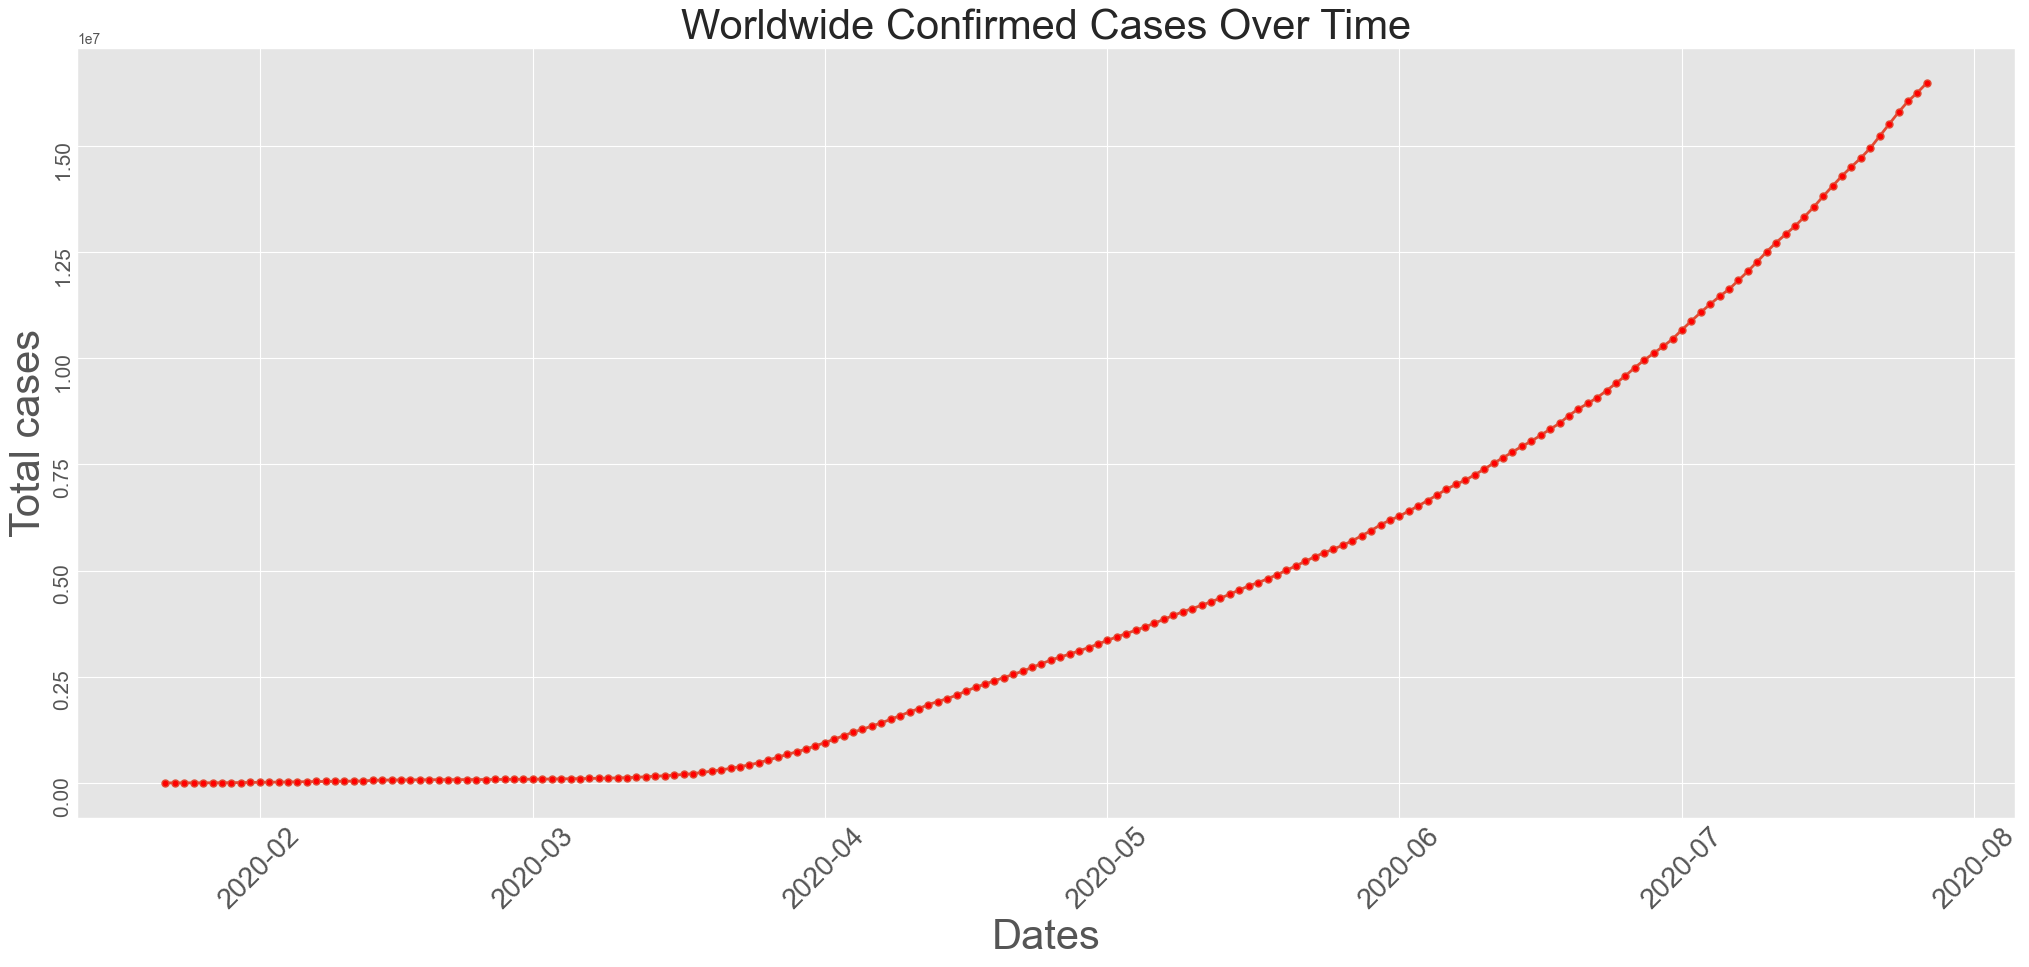

In [296]:
plt.style.use("ggplot")
plt.figure(figsize=(25, 10))
plt.title("Worldwide Confirmed Cases Over Time", fontsize=30)

plt.plot(total_cases['date'], total_cases['confirmed'], linewidth=2, marker='.', markersize=10, markerfacecolor='r')

plt.xlabel("Dates", fontsize=30)
plt.xticks(rotation=45, fontsize=20)

plt.ylabel("Total cases", fontsize=30)
plt.yticks(rotation=90, fontsize=15)

plt.show()

#### Top 20 countries having most death cases

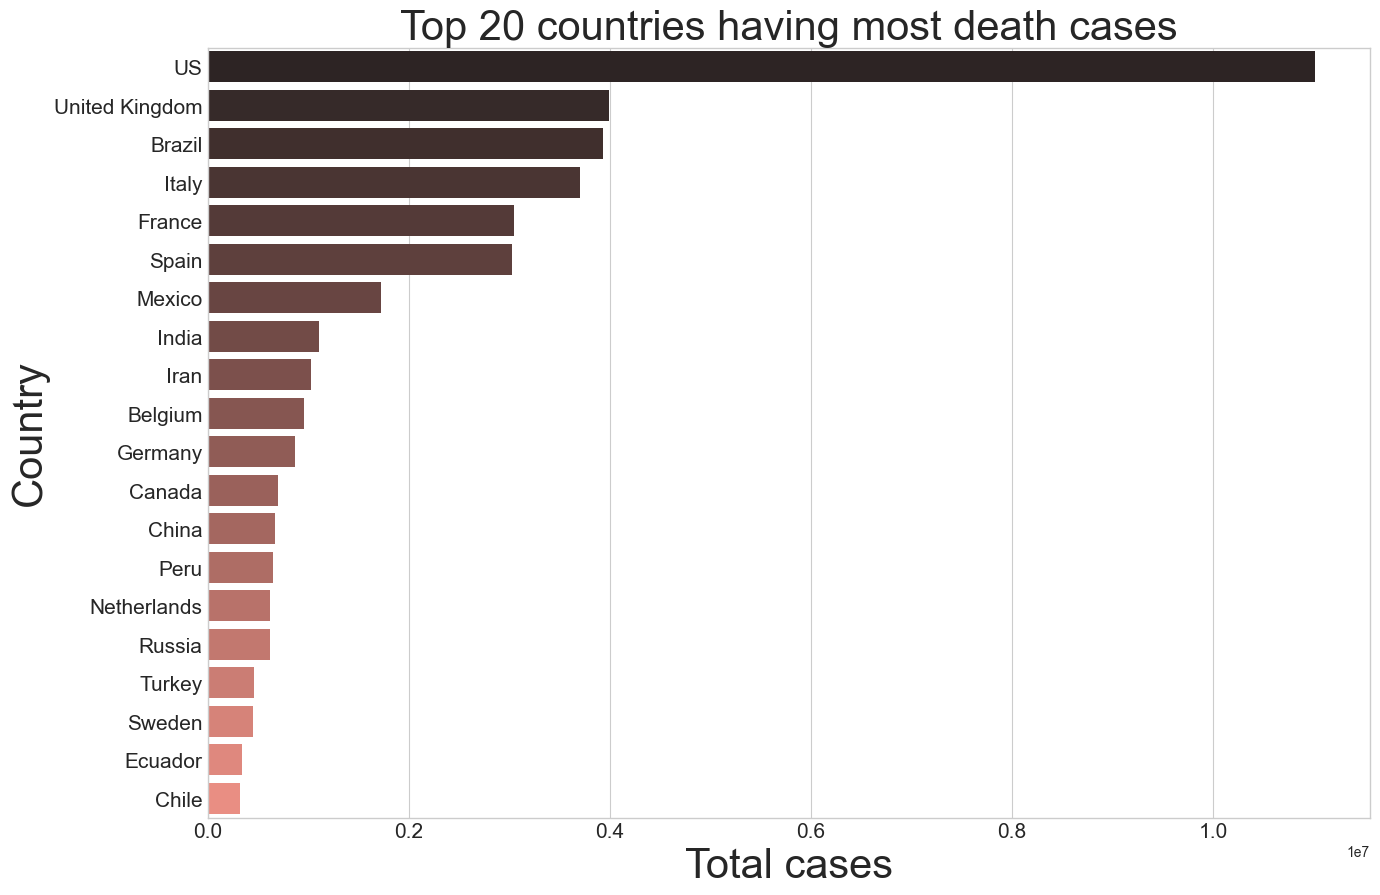

In [297]:
top_deaths = data.groupby(by="country")["deaths"].sum().sort_values(ascending=False).head(20).reset_index()

plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(15,10))
plt.title("Top 20 countries having most death cases",fontsize=30)

sns.barplot(x=top_deaths['deaths'], y=top_deaths['country'], palette='dark:salmon')

plt.xticks(fontsize=15)
plt.xlabel("Total cases",fontsize=30)

plt.yticks(fontsize=15)
plt.ylabel("Country",fontsize=30)

plt.show()

#### Top 20 Countries with highest active cases

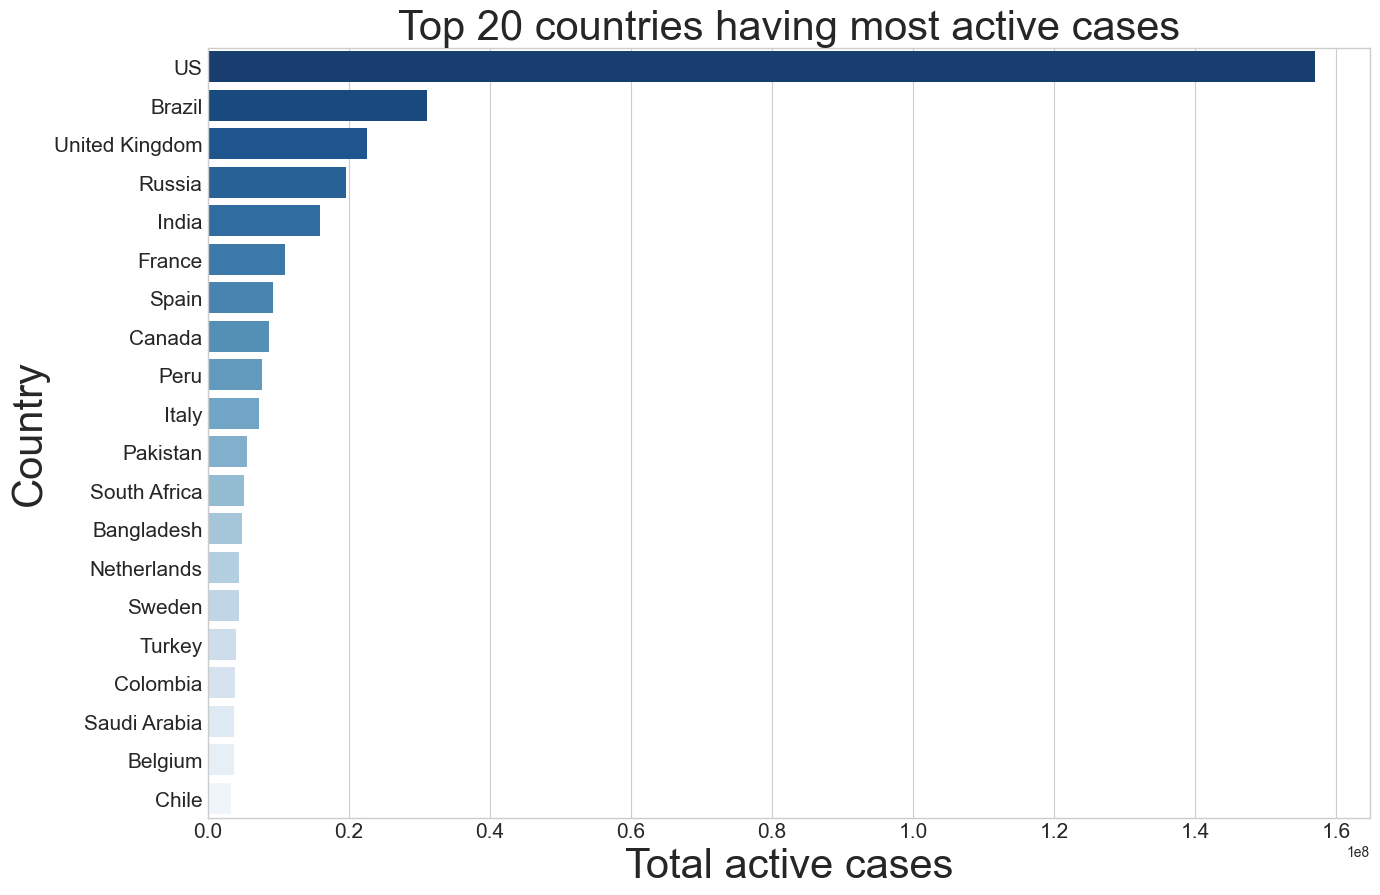

In [298]:
top_actives = data.groupby(by="country")["active"].sum().sort_values(ascending=False).head(20).reset_index()

plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(15,10))
plt.title("Top 20 countries having most active cases", fontsize=30)

sns.barplot(x=top_actives['active'], y=top_actives['country'], palette='Blues_r')

plt.xticks(fontsize=15)
plt.xlabel("Total active cases",fontsize=30)

plt.yticks(fontsize=15)
plt.ylabel("Country",fontsize=30)

plt.show()

#### Top 20 countries having most confirmed cases

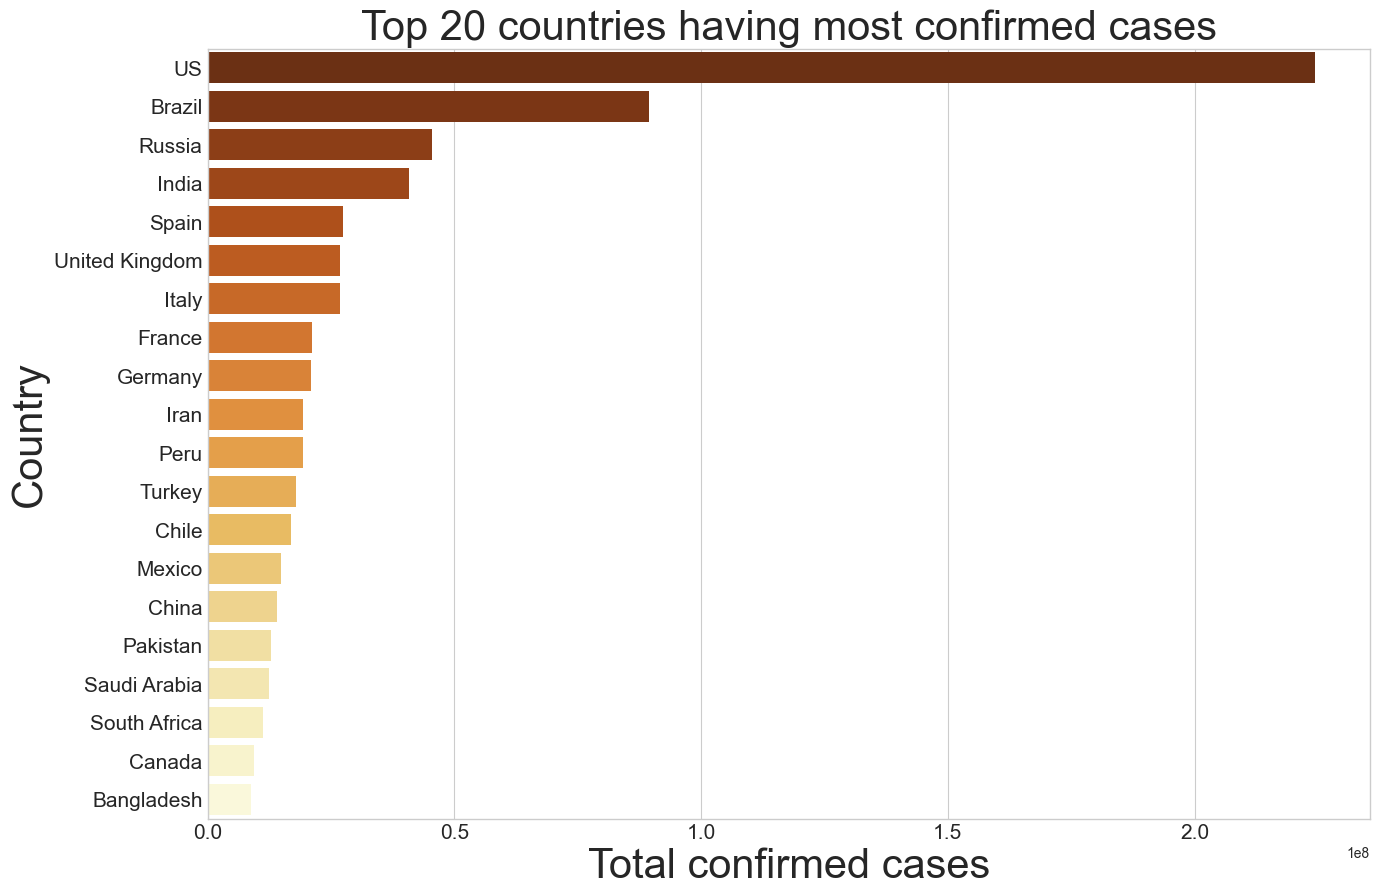

In [299]:
top_confirmed = data.groupby(by="country")["confirmed"].sum().sort_values(ascending=False).head(20).reset_index()

plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(15,10))
plt.title("Top 20 countries having most confirmed cases", fontsize=30)

sns.barplot(x=top_confirmed['confirmed'], y=top_confirmed['country'], palette='YlOrBr_r')

plt.xticks(fontsize=15)
plt.xlabel("Total confirmed cases",fontsize=30)

plt.yticks(fontsize=15)
plt.ylabel("Country",fontsize=30)

plt.show()

### Statistics for Top 5 countries

**Inference:** Top 5 countries having highest active cases are :
1. USA
2. Brazil
3. Russia
4. India
5. Spain

In [300]:
Brazil = data[data['country'] == "Brazil"].groupby(by="date")[["recovered", "deaths", "confirmed", "active"]].sum().reset_index()
USA = data[data['country'] == "US"].groupby(by="date")[["recovered", "deaths", "confirmed", "active"]].sum().reset_index()
Russia = data[data['country'] == "Russia"].groupby(by="date")[["recovered", "deaths", "confirmed", "active"]].sum().reset_index()
India = data[data['country'] == "India"].groupby(by="date")[["recovered", "deaths", "confirmed", "active"]].sum().reset_index()
Spain = data[data['country'] == "Spain"].groupby(by="date")[["recovered", "deaths", "confirmed", "active"]].sum().reset_index()

Brazil

,date,recovered,deaths,confirmed,active
0,2020-01-22,0,0,0,0
1,2020-01-23,0,0,0,0
2,2020-01-24,0,0,0,0
3,2020-01-25,0,0,0,0
4,2020-01-26,0,0,0,0
...,...,...,...,...,...
183,2020-07-23,1620313,84082,2287475,583080
184,2020-07-24,1693214,85238,2343366,564914
185,2020-07-25,1785359,86449,2394513,522705
186,2020-07-26,1812913,87004,2419091,519174


#### Active cases over time

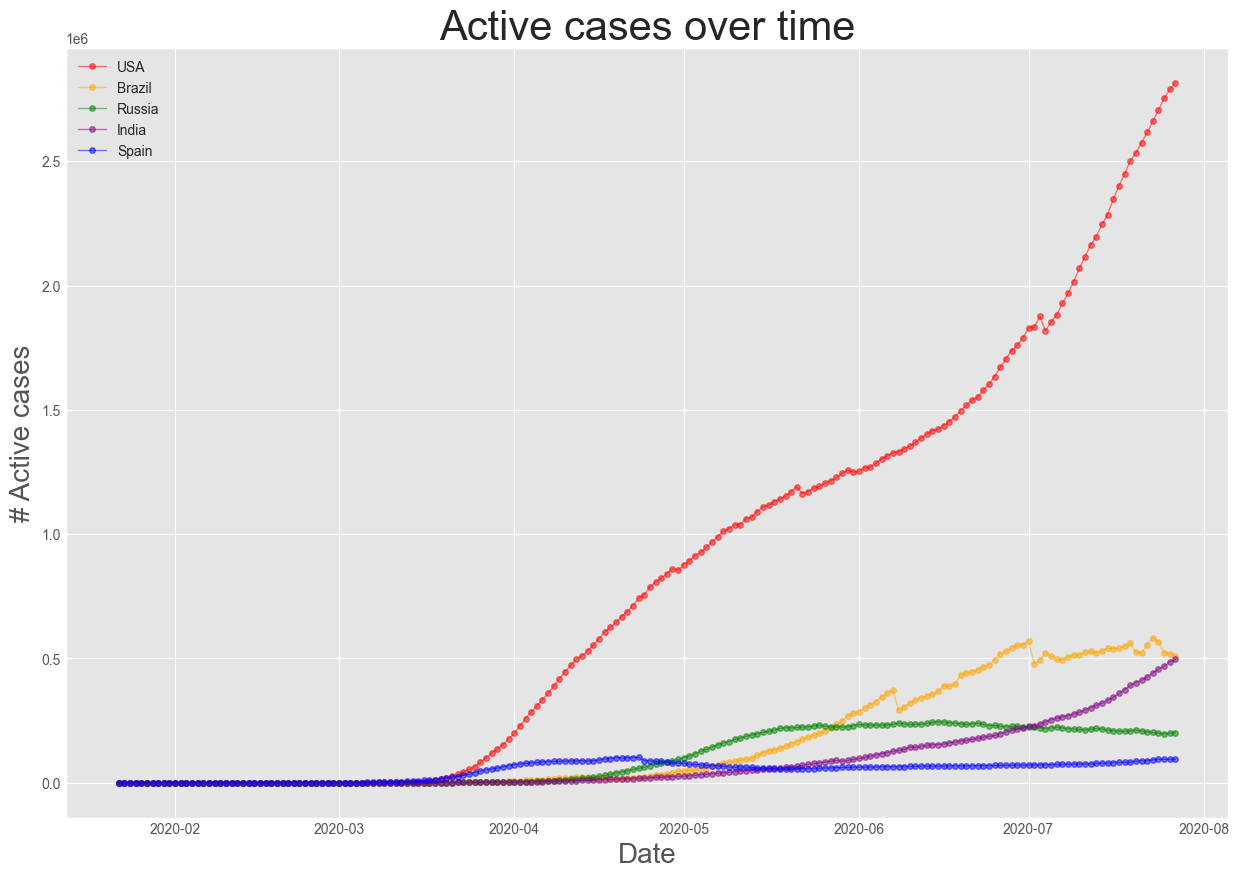

In [301]:
plt.style.use("ggplot")
plt.figure(figsize=(15,10))
plt.title("Active cases over time", fontsize=30)

plt.plot(USA['date'], USA['active'], 'r', alpha=0.5, linewidth=1, marker='.', markersize=8, label="USA")
plt.plot(Brazil['date'], Brazil['active'], 'orange', alpha=0.5, linewidth=1, marker='.', markersize=8, label="Brazil")
plt.plot(Russia['date'], Russia['active'], 'green', alpha=0.5, linewidth=1, marker='.', markersize=8, label="Russia")
plt.plot(India['date'], India['active'], 'purple', alpha=0.5, linewidth=1, marker='.', markersize=8, label="India")
plt.plot(Spain['date'], Spain['active'], 'blue', alpha=0.5, linewidth=1, marker='.', markersize=8, label="Spain")

plt.xlabel('Date', fontsize=20)
plt.ylabel('# Active cases', fontsize=20)
plt.legend(loc='upper left')
plt.show()

#### Confirmed cases over time

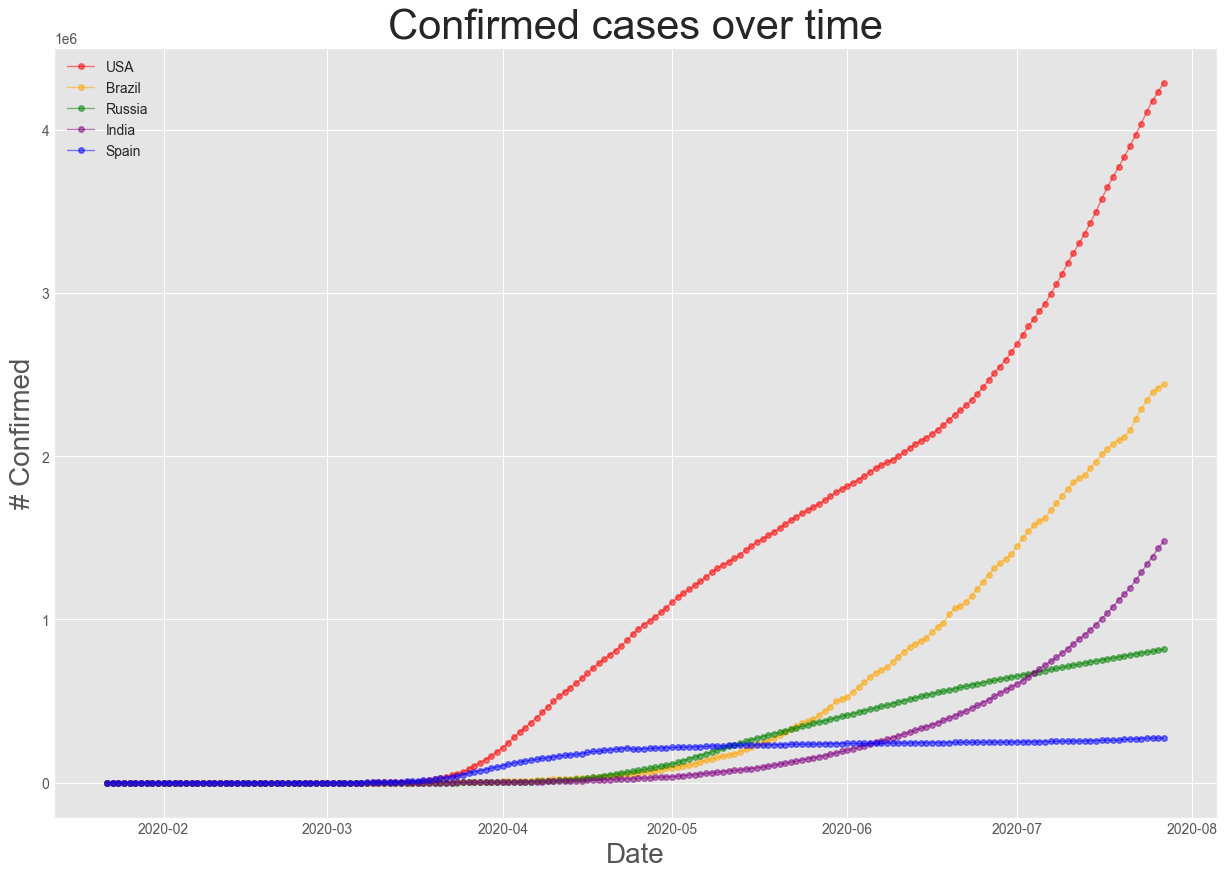

In [302]:
plt.style.use("ggplot")
plt.figure(figsize=(15,10))
plt.title("Confirmed cases over time", fontsize=30)

plt.plot(USA['date'], USA['confirmed'], 'r', alpha=0.5, linewidth=1, marker='.', markersize=8, label="USA")
plt.plot(Brazil['date'], Brazil['confirmed'], 'orange', alpha=0.5, linewidth=1, marker='.', markersize=8, label="Brazil")
plt.plot(Russia['date'], Russia['confirmed'], 'green', alpha=0.5, linewidth=1, marker='.', markersize=8, label="Russia")
plt.plot(India['date'], India['confirmed'], 'purple', alpha=0.5, linewidth=1, marker='.', markersize=8, label="India")
plt.plot(Spain['date'], Spain['confirmed'], 'blue', alpha=0.5, linewidth=1, marker='.', markersize=8, label="Spain")

plt.xlabel('Date', fontsize=20)
plt.ylabel('# Confirmed', fontsize=20)
plt.legend(loc='upper left')
plt.show()

#### Deaths over time

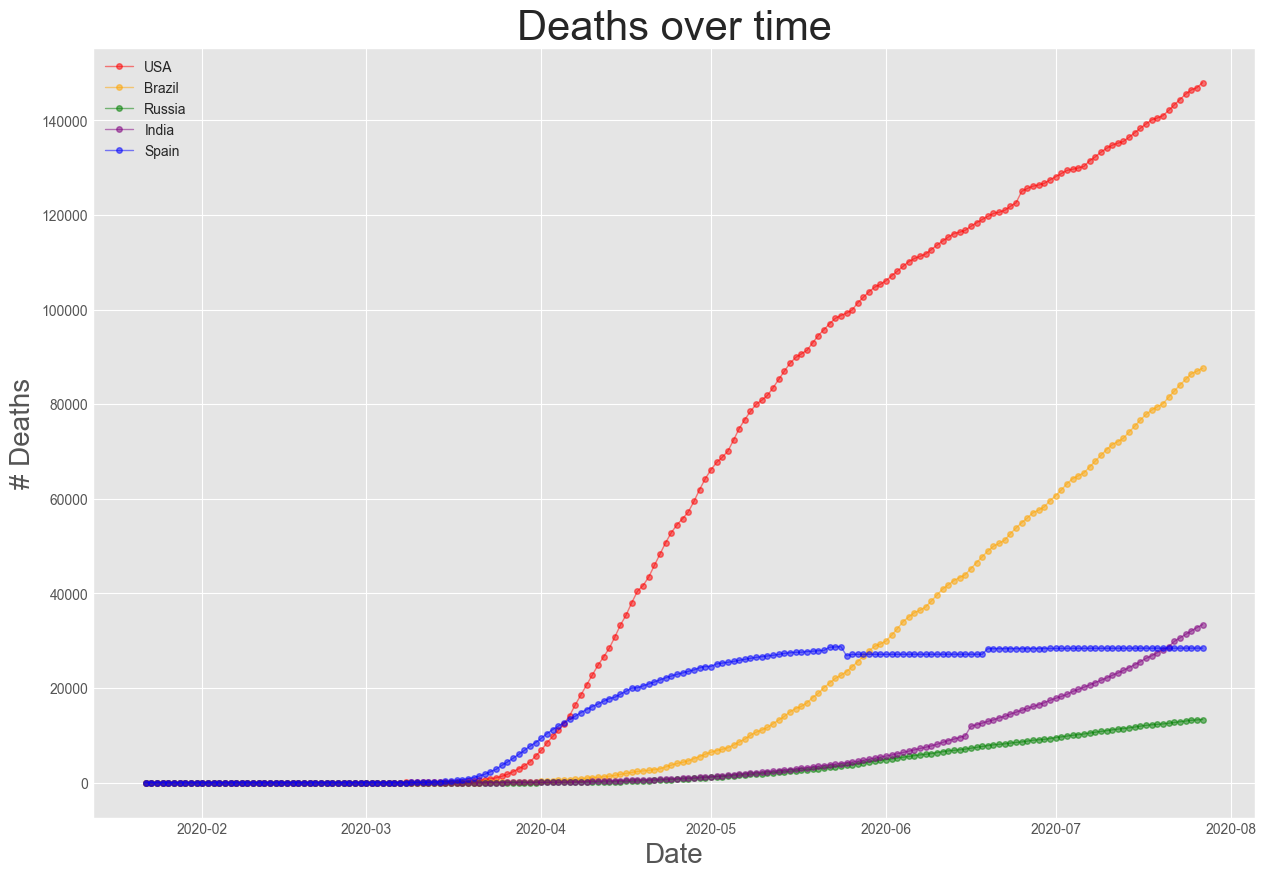

In [303]:
plt.style.use("ggplot")
plt.figure(figsize=(15,10))
plt.title("Deaths over time", fontsize=30)

plt.plot(USA['date'], USA['deaths'], 'r', alpha=0.5, linewidth=1, marker='.', markersize=8, label="USA")
plt.plot(Brazil['date'], Brazil['deaths'], 'orange', alpha=0.5, linewidth=1, marker='.', markersize=8, label="Brazil")
plt.plot(Russia['date'], Russia['deaths'], 'green', alpha=0.5, linewidth=1, marker='.', markersize=8, label="Russia")
plt.plot(India['date'], India['deaths'], 'purple', alpha=0.5, linewidth=1, marker='.', markersize=8, label="India")
plt.plot(Spain['date'], Spain['deaths'], 'blue', alpha=0.5, linewidth=1, marker='.', markersize=8, label="Spain")

plt.xlabel('Date', fontsize=20)
plt.ylabel('# Deaths', fontsize=20)
plt.legend(loc='upper left')
plt.show()

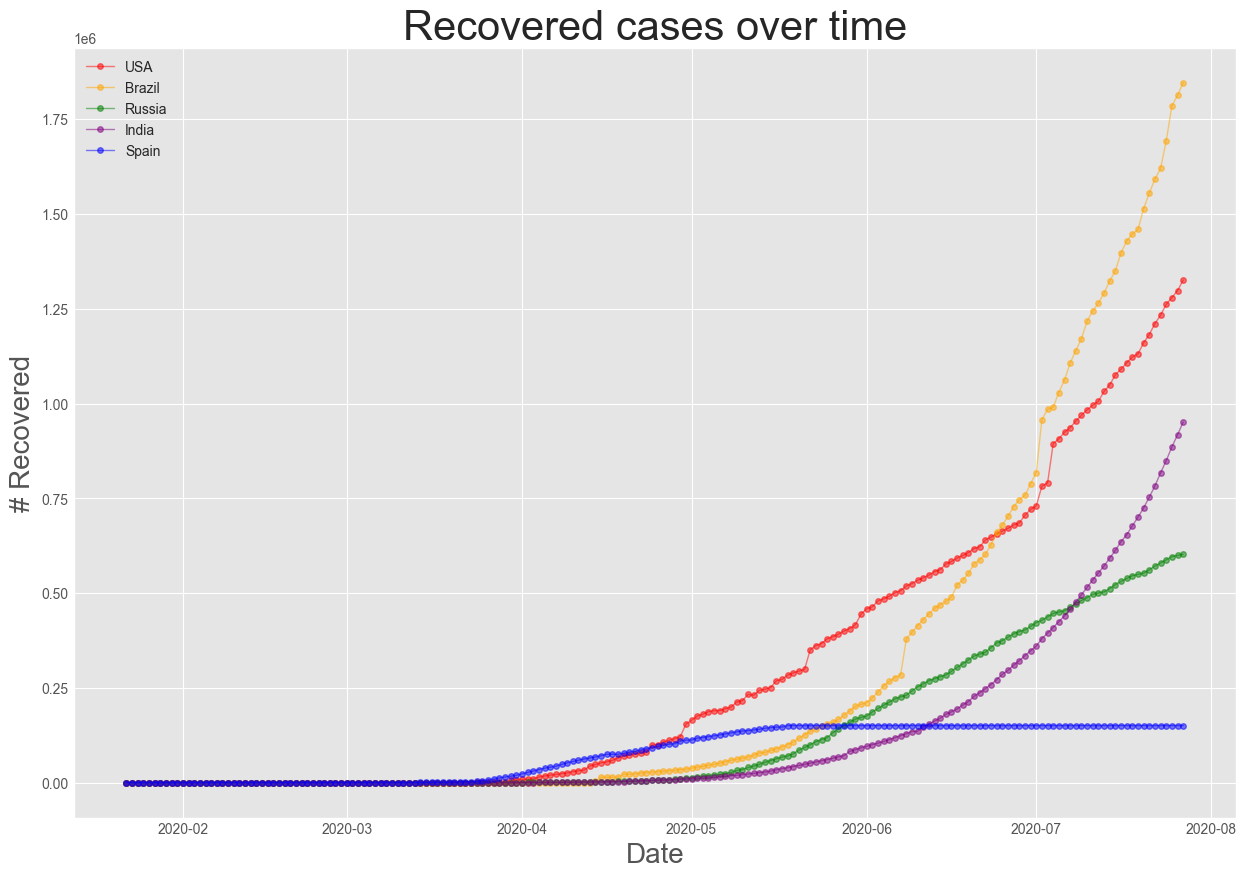

In [304]:
plt.style.use("ggplot")
plt.figure(figsize=(15,10))
plt.title("Recovered cases over time", fontsize=30)

plt.plot(USA['date'], USA['recovered'], 'r', alpha=0.5, linewidth=1, marker='.', markersize=8, label="USA")
plt.plot(Brazil['date'], Brazil['recovered'], 'orange', alpha=0.5, linewidth=1, marker='.', markersize=8, label="Brazil")
plt.plot(Russia['date'], Russia['recovered'], 'green', alpha=0.5, linewidth=1, marker='.', markersize=8, label="Russia")
plt.plot(India['date'], India['recovered'], 'purple', alpha=0.5, linewidth=1, marker='.', markersize=8, label="India")
plt.plot(Spain['date'], Spain['recovered'], 'blue', alpha=0.5, linewidth=1, marker='.', markersize=8, label="Spain")

plt.xlabel('Date', fontsize=20)
plt.ylabel('# Recovered', fontsize=20)
plt.legend(loc='upper left')
plt.show()

## Forecasting using Facebook Prophet


For building a forecasting model using fbProphet library, there should be only 2 columns passed and the column names should always be --> 'ds','y'.

In [305]:
confirmed = data.groupby("date").sum()["confirmed"].reset_index()
deaths = data.groupby("date").sum()["deaths"].reset_index()
recovered = data.groupby("date").sum()["recovered"].reset_index()
active = data.groupby("date").sum()["active"].reset_index()

confirmed.rename(columns={"date": "ds", "confirmed": "y"}, inplace=True)
deaths.rename(columns={"date": "ds", "deaths": "y"}, inplace=True)
recovered.rename(columns={"date": "ds", "recovered": "y"}, inplace=True)
active.rename(columns={"date": "ds", "active": "y"}, inplace=True)

### Forecasting for the confirmed cases

In [306]:
confirmed

,ds,y
0,2020-01-22,555
1,2020-01-23,654
2,2020-01-24,941
3,2020-01-25,1434
4,2020-01-26,2118
...,...,...
183,2020-07-23,15510481
184,2020-07-24,15791645
185,2020-07-25,16047190
186,2020-07-26,16251796


In [307]:
# Instantiating a new Prophet object
model = Prophet()

# Fit historical DataFrame
model.fit(confirmed)

# Store the predictions
future = model.make_future_dataframe(periods=7, include_history=True)
future.tail(7)

18:06:31 - cmdstanpy - INFO - Chain [1] start processing
18:06:31 - cmdstanpy - INFO - Chain [1] done processing


,ds
188,2020-07-28
189,2020-07-29
190,2020-07-30
191,2020-07-31
192,2020-08-01
193,2020-08-02
194,2020-08-03


In [308]:
# Making predictions on the dates from fitted model
forecast = model.predict(future)
forecast[["ds","yhat","yhat_lower","yhat_upper"]]

,ds,yhat,yhat_lower,yhat_upper
0,2020-01-22,-2.034240e+04,-1.273440e+05,8.119335e+04
1,2020-01-23,-7.746625e+03,-1.183978e+05,9.626750e+04
2,2020-01-24,6.123967e+03,-9.285319e+04,1.084441e+05
3,2020-01-25,1.237938e+04,-9.828508e+04,1.174202e+05
4,2020-01-26,8.615766e+03,-9.492144e+04,1.143350e+05
...,...,...,...,...
190,2020-07-30,1.674820e+07,1.663821e+07,1.685085e+07
191,2020-07-31,1.696362e+07,1.684948e+07,1.706083e+07
192,2020-08-01,1.717143e+07,1.705767e+07,1.728485e+07
193,2020-08-02,1.736922e+07,1.724979e+07,1.747574e+07


In [309]:
plot_plotly(model, forecast)

In [310]:
plot_components_plotly(model, forecast)

### Forecasting all attributes

In [311]:
# Initialize DataFrame to store metrics
model_metrics = pd.DataFrame(columns=['mape', 'rmse', 'r2'])

def evaluate_forecast(type, y_true, y_pred):
    model_metrics.loc[type, 'mape'] = mean_absolute_percentage_error(y_true, y_pred)
    model_metrics.loc[type, 'rmse'] = mean_squared_error(y_true, y_pred, squared=False)
    model_metrics.loc[type, 'r2'] = r2_score(y_true, y_pred)
    
    return model_metrics

In [312]:
# data = {"CONFIRMED": confirmed, "DEATHS": deaths, "RECOVERED": recovered, "ACTIVE": active}
# predictions = []

# for key, value in data.items():
#     # Instantiating a new Prophet object
#     model = Prophet()

#     # Fitting the historical DataFrame
#     model.fit(value)

#     # DataFrame to store predictions
#     future = model.make_future_dataframe(periods=7, include_history=True)

#     # Making predictions for the future
#     forecast = model.predict(future)

#     # Appending forecast to predictions list
#     predictions.append(forecast)

#     print("#" * 50, key, "#" * 50)

#     # Plotting the forecast
#     model.plot(forecast)
#     plt.title(f"Predictions for {key.title()} by Prophet Model")
#     plt.show()

#     # Plotting the components
#     model.plot_components(forecast)
#     plt.show()

#     # Evaluate performance on the training data
#     y_true = value['y'].values
#     y_pred = forecast['yhat'].values[:len(y_true)]

#     metrics_df = evaluate_forecast(key, y_true, y_pred)

# display(model_metrics)

18:06:31 - cmdstanpy - INFO - Chain [1] start processing
18:06:31 - cmdstanpy - INFO - Chain [1] done processing


################################################## CONFIRMED ##################################################


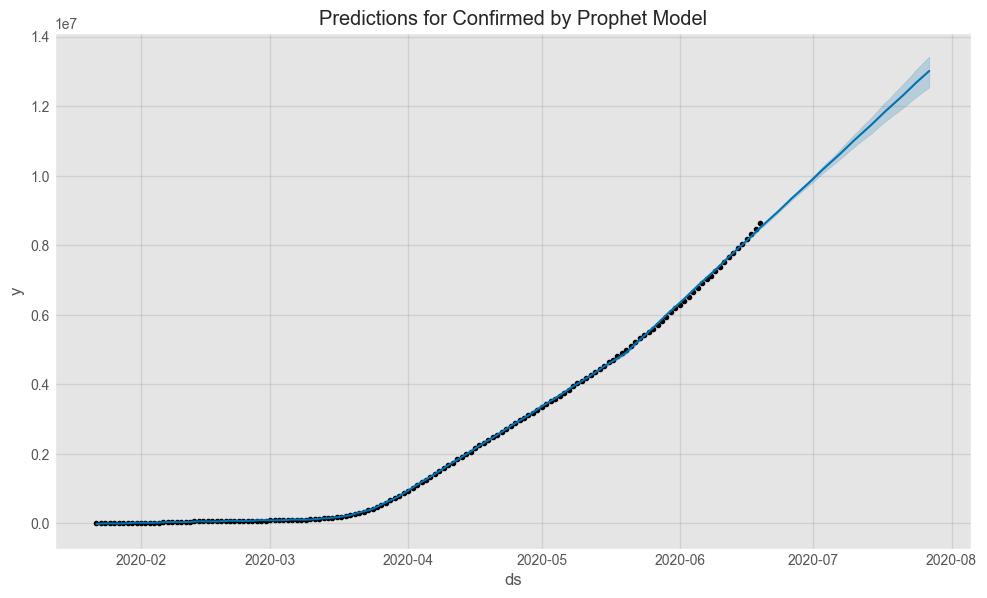

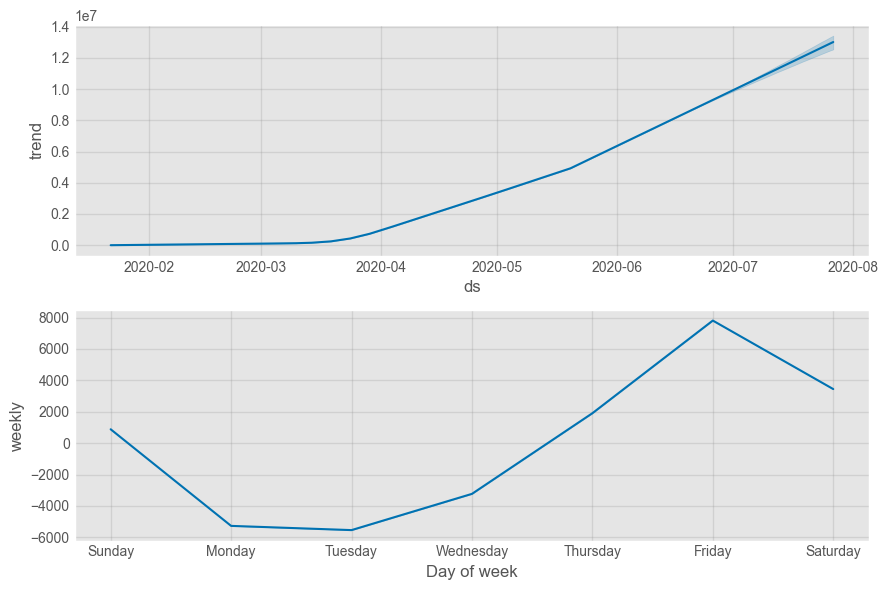

18:06:31 - cmdstanpy - INFO - Chain [1] start processing
18:06:31 - cmdstanpy - INFO - Chain [1] done processing


################################################## DEATHS ##################################################


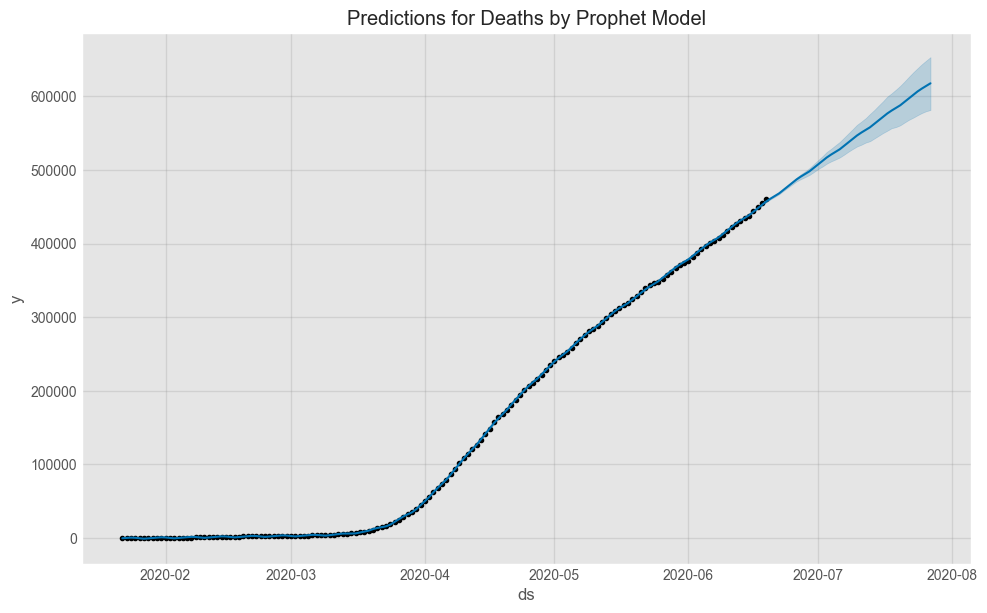

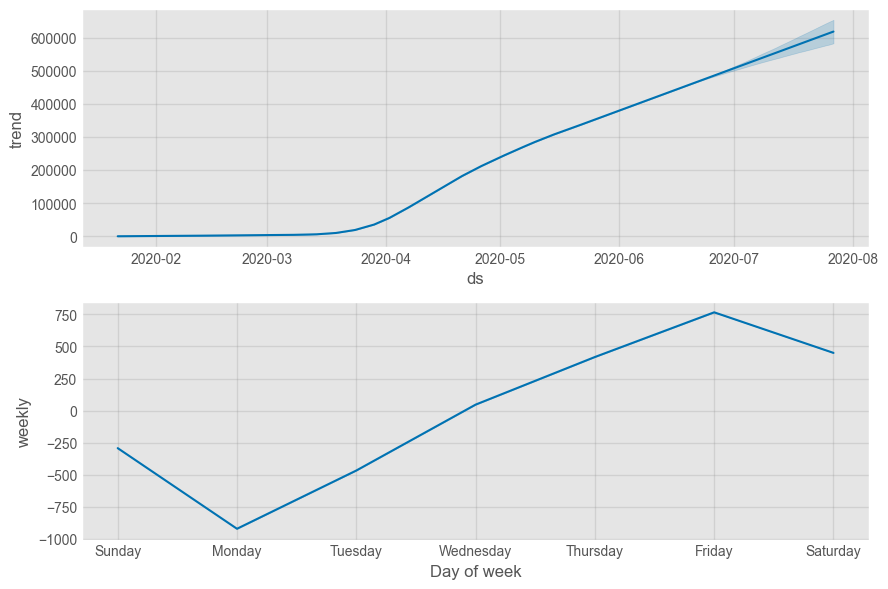

18:06:31 - cmdstanpy - INFO - Chain [1] start processing
18:06:31 - cmdstanpy - INFO - Chain [1] done processing


################################################## RECOVERED ##################################################


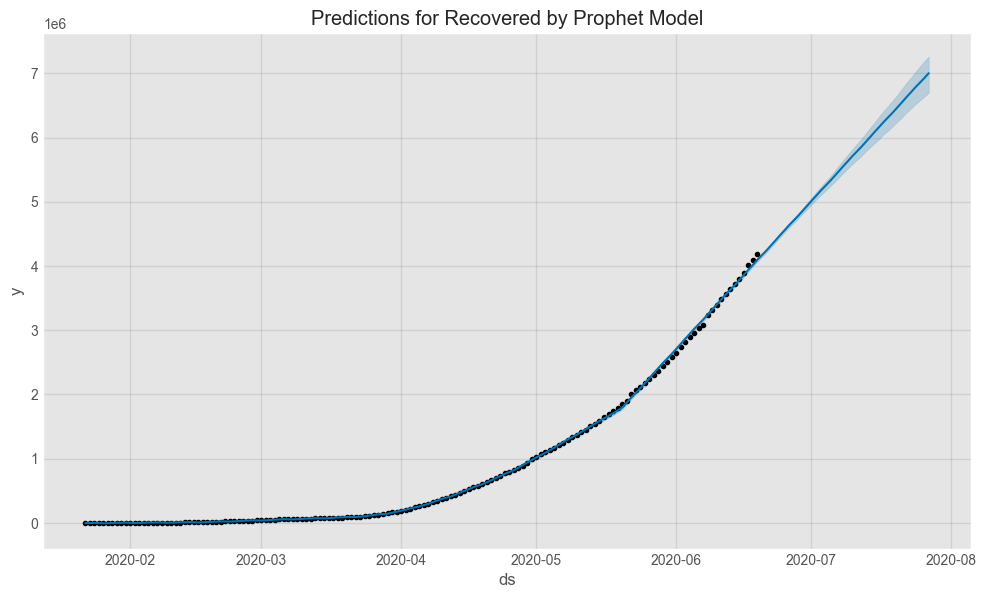

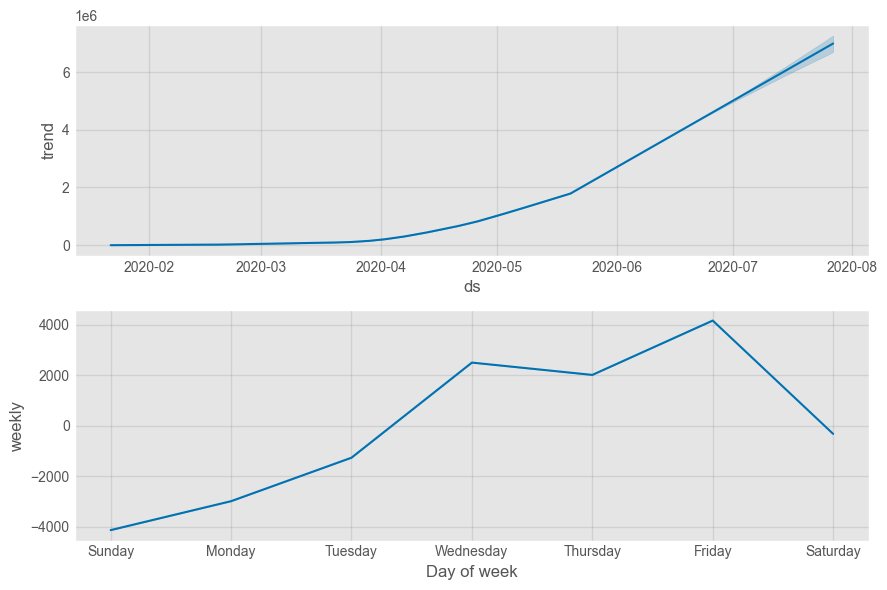

18:06:32 - cmdstanpy - INFO - Chain [1] start processing
18:06:32 - cmdstanpy - INFO - Chain [1] done processing


################################################## ACTIVE ##################################################


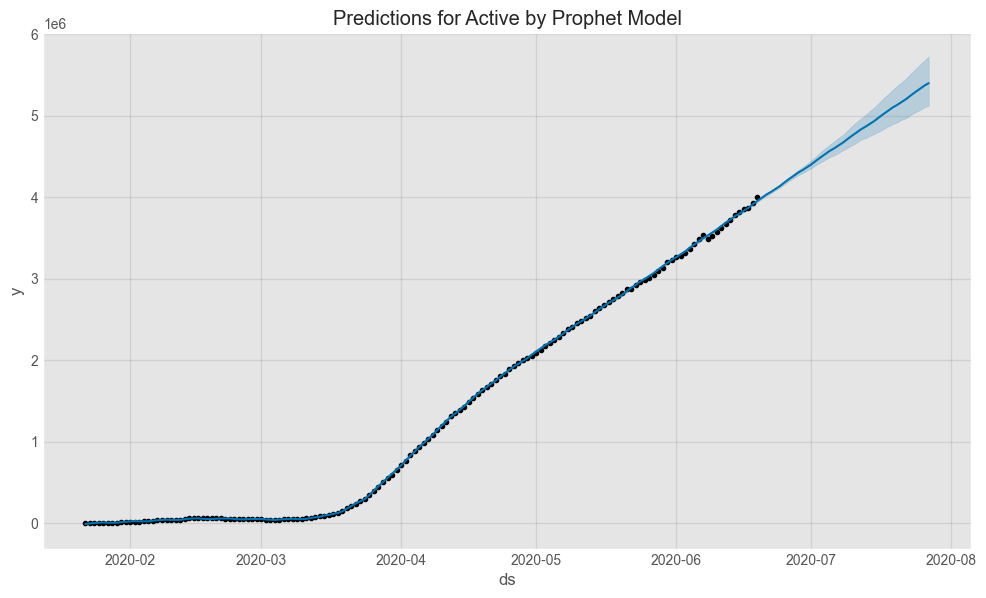

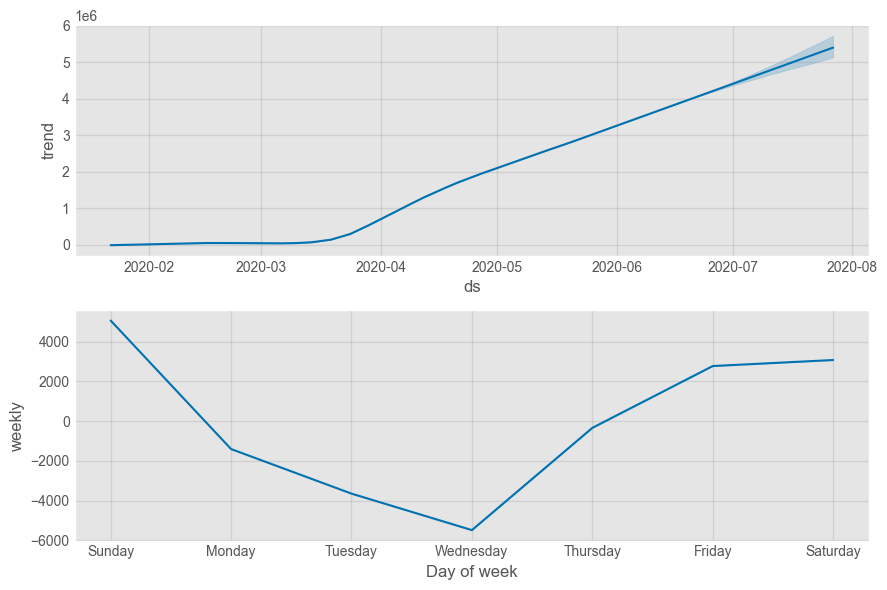

,mape,rmse,r2
CONFIRMED,0.111591,1811713.555352,0.379547
DEATHS,0.02617,17811.09275,0.897382
RECOVERED,0.141024,1268028.366545,0.330296
ACTIVE,0.081269,530390.8733,0.421888


In [313]:
data = {"CONFIRMED": confirmed, "DEATHS": deaths, "RECOVERED": recovered, "ACTIVE": active}
predictions = []

for key, value in data.items():
    # Split data into training and test sets
    train_size = int(0.8 * len(value))
    train = value.iloc[:train_size]
    test = value.iloc[train_size:]

    # Instantiating a new Prophet object
    model = Prophet()

    # Fitting the historical DataFrame
    model.fit(train)

    # DataFrame to store predictions
    future = model.make_future_dataframe(periods=len(test), include_history=True)

    # Making predictions for the future
    forecast = model.predict(future)

    # Appending forecast to predictions list
    predictions.append(forecast)

    print("#" * 50, key, "#" * 50)

    # Plotting the forecast
    model.plot(forecast)
    plt.title(f"Predictions for {key.title()} by Prophet Model")
    plt.show()

    # Plotting the components
    model.plot_components(forecast)
    plt.show()

    # Evaluate performance on the test data
    y_true = test['y'].values
    y_pred = forecast['yhat'].values[-len(test):]

    metrics_df = evaluate_forecast(key, y_true, y_pred)

display(model_metrics)

<span  style="color: gold; text-align: center;">

# Inferences
</span>

### *Visual Inspection*
On visual inspection of the plots provided by the Prophet library we make these inferences:
- **Upward Trend:** The upward trend observed in all attributes, including confirmed cases, deaths, active cases, and recovered cases, indicates a continuous rise in the impact of COVID-19 globally. It suggests that the spread of the virus is not slowing down, and the situation is evolving rapidly.
- **Weekly Seasonality:** The presence of a distinct weekly seasonality, resembling a sine wave, with a minima around Monday-Tuesday and a maxima around Friday-Saturday is noteworthy.
<br>

**Thoughts on weekly seasonality:** The observed weekly seasonality in COVID-19 attributes can be rationalized based on human behaviour, societal patterns, and reporting dynamics:
 - **Workweek Impact:** The lower counts at the beginning of the week may be influenced by reduced testing, reporting delays, or decreased social activities during the early workweek. Similarly, the higher counts towards the end of the week could be linked to increased testing, more social interactions, and potentially delayed reporting catching up from earlier in the week.
 - **Testing Patterns:** Variations in testing availability and practices might contribute to the observed weekly patterns, with increased testing leading to higher reported cases.
 - **Reporting Delays:** Delays in data reporting, especially over weekends, might result in a surge of reported cases at the beginning of the new week.
 - **Weekend Gatherings:** Social activities, gatherings, or events over the early weekend might contribute to increased exposure and transmission, leading to higher reported cases.
 - **Workweek Caution:** Individuals might exhibit more caution and adherence to safety measures early in the workweek, potentially influencing lower reported cases. However, as the week progresses, there appears to be a relaxation in this vigilance, potentially leading to a more casual approach to safety protocols.

### *Model Performance*
1. **MAPE (Mean Absolute Percentage Error)**:
   - Measures the accuracy as a percentage.
   - Lower values are better. Values around 0.1 (10%) indicate good performance.
   - CONFIRMED: 11.16% - Quite reasonable.
   - DEATHS: 2.62% - Very good.
   - RECOVERED: 14.10% - Slightly higher but still reasonable.
   - ACTIVE: 8.13% - Good.

2. **RMSE (Root Mean Squared Error)**:
   - Measures the standard deviation of the prediction errors.
   - Lower values are better. The absolute value depends on the scale of the data.
   - CONFIRMED: 1,811,713 - The scale might be large for confirmed cases, so this might be acceptable.
   - DEATHS: 17,811 - Lower values are better, and this is a relatively good value.
   - RECOVERED: 1,268,028 - The scale might be large for recovered cases as well.
   - ACTIVE: 530,391 - This could be acceptable depending on the scale of active cases.

3. **R² (R-squared) Score**:
   - Measures the proportion of variance explained by the model.
   - Values range from 0 to 1, with higher values indicating better performance.
   - CONFIRMED: 0.3795 - This indicates that the model explains about 37.95% of the variance. It’s relatively low.
   - DEATHS: 0.8974 - Indicates that the model explains about 89.74% of the variance. Very good.
   - RECOVERED: 0.3303 - Similar to CONFIRMED, indicating a lower performance.
   - ACTIVE: 0.4219 - Slightly better than CONFIRMED and RECOVERED, but still not very high.

#### Interpretation:
- **DEATHS** has the best performance across all metrics, indicating the model predicts the number of deaths quite accurately.
- **CONFIRMED**, **RECOVERED**, and **ACTIVE** show reasonable MAPE values but lower R² scores, suggesting that the model captures the general trend but misses some variability.

#### Possible Actions:
1. **Data Quality and Preprocessing**:
   - Ensure the data is clean and preprocessed properly.
   - Consider adding additional features (like holidays or events) that might affect the time series.

2. **Model Tuning**:
   - Experiment with different Prophet hyperparameters.
   - Consider using other time series forecasting models (ARIMA, LSTM, etc.) for comparison.

3. **Seasonality and Trends**:
   - Check if the model is correctly capturing seasonality and trends.
   - Consider adding custom seasonalities if the default ones are not sufficient.

4. **Cross-validation**:
   - Use cross-validation to ensure the model's performance is stable over different time periods.

Overall, the metrics are reasonable but suggest room for improvement, particularly for the CONFIRMED and RECOVERED series.